<a href="https://colab.research.google.com/github/AlexandreAdam/ExoRIM/blob/master/notebooks/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone https://github.com/AlexandreAdam/ExoRIM.git
%cd ExoRIM
!git checkout dev
!python setup.py develop

fatal: destination path 'ExoRIM' already exists and is not an empty directory.
/content/ExoRIM
Already on 'dev'
Your branch is up to date with 'origin/dev'.
running develop
running egg_info
writing exorim.egg-info/PKG-INFO
writing dependency_links to exorim.egg-info/dependency_links.txt
writing top-level names to exorim.egg-info/top_level.txt
writing manifest file 'exorim.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/exorim.egg-link (link to .)
exorim 0.9.0 is already the active version in easy-install.pth

Installed /content/ExoRIM
Processing dependencies for exorim==0.9.0
Finished processing dependencies for exorim==0.9.0


In [5]:
from exorim import RIM, PhysicalModel
from exorim.simulated_data import CenteredBinariesDataset 
from exorim.definitions import DTYPE, rad2mas
from exorim.physical_model import GOLAY9, JWST_NIRISS_MASK
from exorim.models.modelv2 import Model as Modelv2
from exorim.models.rim_unet_model import UnetModel


from argparse import ArgumentParser
from datetime import datetime
import tensorflow as tf
import numpy as np
import json
import os
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
from glob import glob
import collections
import pickle
from IPython.display import HTML

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [24]:
parser = ArgumentParser()
parser.add_argument("--pixels", type=int, default=32, help="Size of the reconstructed image")
parser.add_argument("--log_floor", type=float, default=1e-3, help="Set the dynamic range of the model")
parser.add_argument("--wavelength", type=float, default=3.8e-6, help="Wavelength of the observed light in meters")
parser.add_argument("--oversampling_factor", type=float, default=2.5, help="How small to set plate scale relative to the Michelson criteria")
parser.add_argument("--noise_std", type=float, default=1e-3)
parser.add_argument("--learning_rate", type=float, default=1e-4)
parser.add_argument("--decay_rate", type=float, default=1)
parser.add_argument("--decay_steps", type=int, default=50)
parser.add_argument("--total_items", type=int, default=10)
parser.add_argument("--split", type=float, default=0.8)
parser.add_argument("--batch_size", type=int, default=1, help="Batch size")
parser.add_argument("--max_epoch", type=int, default=100, help="Maximum number of epoch")
parser.add_argument("--seed", type=float, default=42, help="Dataset seed")

args, unknown = parser.parse_known_args()


phys = PhysicalModel( # GOLAY9 mask
    pixels=args.pixels,
    mask_coordinates=JWST_NIRISS_MASK,
    wavelength=args.wavelength,
    logim=True,
    oversampling_factor=args.oversampling_factor,
    # chi_squared="visibility" # comment to get visibility amplitude + closure phase problem
)

def sigma_distribution(batch_size, nbuv):
    # return np.ones(shape=nbuv)[None, :] * np.random.uniform(low=1e-4, high=1e-2, size=batch_size)[:, None]
    return np.ones(shape=(batch_size, nbuv)) * args.noise_std
  
dataset = CenteredBinariesDataset(
    phys,
    sigma_distribution=sigma_distribution,
    total_items=args.total_items, 
    batch_size=args.batch_size, 
    width=2, 
    seed=10)

model = Modelv2(
    filters=64,
    filter_scaling=2,
    kernel_size=3,
    layers=2,
    block_conv_layers=3,
    strides=2,
    activation="tanh"
)

rim = RIM(model, physical_model=phys, adam=True, time_steps=4, log_floor=args.log_floor)

learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=args.learning_rate,
    decay_rate=args.decay_rate,
    decay_steps=args.decay_steps
)
optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate_schedule)

start = time.time()
epoch = 1
history = {"train_loss": [], "chi_squared": []}
min_score = np.inf
epoch_loss = tf.metrics.Mean()
epoch_chisq = tf.metrics.Mean()

step = 1
max_epochs = args.max_epoch
max_time = 0.5
while  epoch < max_epochs and (time.time() - start) < max_time*3600:
    epoch_loss.reset_states()
    epoch_chisq.reset_states()
    batch = 0
    for (X, Y, sigma) in dataset:
        batch += 1
        with tf.GradientTape() as tape:
            tape.watch(rim.model.trainable_weights)
            output, chi_squared = rim.call(X, sigma)
            # cost_value = tf.reduce_sum((output - rim.inverse_link_function(Y))**2, axis=(1, 2, 3))
            cost_value = tf.reduce_sum((Y + rim.log_floor) / tf.reduce_sum((Y + rim.log_floor)) * (output - rim.inverse_link_function(Y))**2, axis=(1, 2, 3))
            cost_value = tf.reduce_mean(cost_value)
            # cost_value += tf.reduce_sum(rim.model.losses)  # Add layer specific regularizer losses (L2 in definitions)
        epoch_loss.update_state([cost_value])
        epoch_chisq.update_state([chi_squared[-1, 0]])
        gradient = tape.gradient(cost_value, rim.model.trainable_weights)
        # gradient = [tf.clip_by_value(grad, -10, 10) for grad in gradient]
        optimizer.apply_gradients(zip(gradient, rim.model.trainable_weights))

        # back to image space for analysis
        output = rim.inverse_link_function(output)
        step += 1
    history["train_loss"].append(epoch_loss.result().numpy())
    history["chi_squared"].append(epoch_loss.result().numpy())
    print(epoch_loss.result().numpy())
    epoch += 1


0.37181646
0.3393102
0.3112553
0.28879043
0.27275962
0.25137234
0.23745129
0.24080057
0.24351141
0.23313172
0.2234334
0.21841235
0.21270967
0.20685601
0.20096889
0.20529297
0.20491807
0.1970225
0.19108385
0.1886541
0.18596913
0.18291152
0.1801788
0.17706606
0.176083
0.17341378
0.17151284
0.1683695
0.16712327
0.16530862
0.16435185
0.16212992
0.1611084
0.15930381
0.15973227
0.15961525
0.16469358
0.16425535
0.16436684
0.15703532
0.16243838
0.24272561
0.23470159
0.2021406
0.17789933
0.168835
0.16294819
0.15853524
0.16417408
0.17241232
0.16486661
0.16068834
0.15714669
0.15557249
0.15451288
0.15259556
0.14987282
0.14809513
0.14633736
0.14561574
0.14406037
0.14316282
0.142098
0.1418558
0.13936155
0.13983068
0.13822867
0.13775653
0.13768134
0.13737598
0.13610306
0.13502356
0.13485695
0.1341194
0.1331853
0.13236909
0.13287783
0.13365376
0.13229504
0.13078701
0.13023026
0.13070627
0.1342043
0.13810854
0.13656455
0.13555269
0.1336959
0.1312672
0.12771706
0.12724277
0.12634945
0.12294785
0.1224205

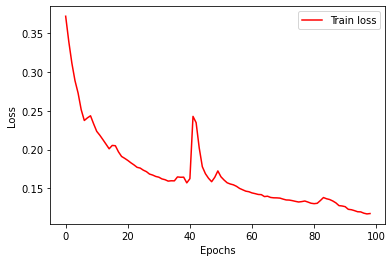

In [25]:
train_loss = history["train_loss"]
plt.figure()
plt.plot(train_loss, "-r", label="Train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
# plt.yscale("log")

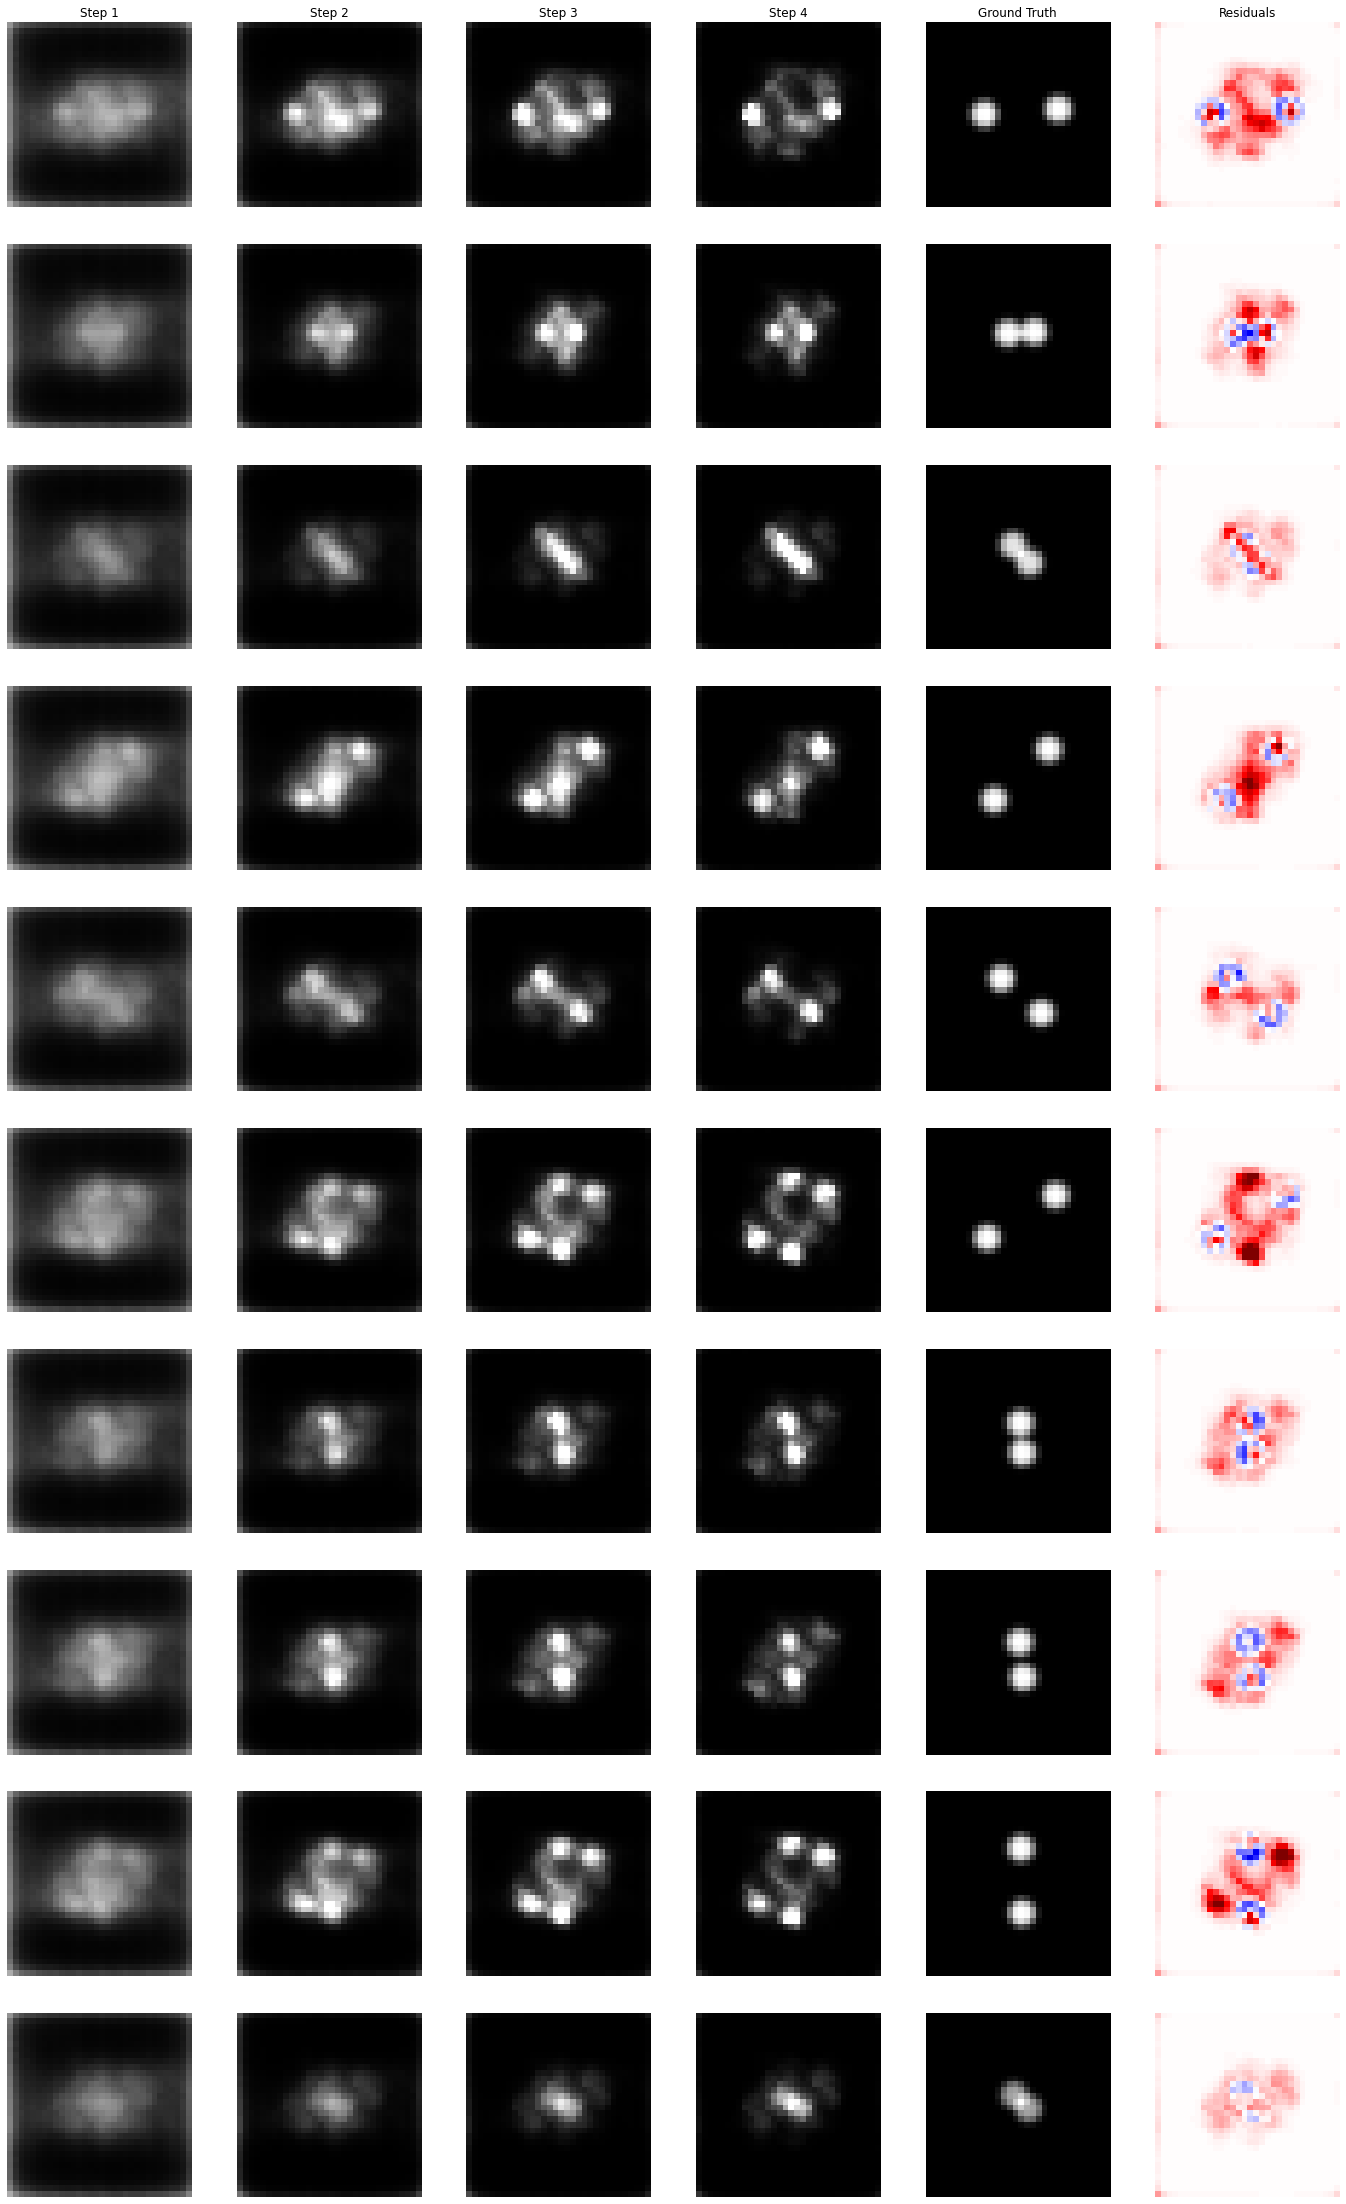

In [26]:
N = 10
fig,axs = plt.subplots(N, 6, figsize=(6*4, N*4))
# fig.suptitle("Image reconstruction process", fontsize=16)
for j in range(N):
    X, Y, sigma = dataset[j]
    out = rim.link_function(rim.call(X, sigma)[0])
    # out = rim.call(X, sigma)[0]
    for i in range(4):
        axs[j, i].imshow(out[i, 0, ..., 0], cmap="gray", origin="lower", vmin=0, vmax=1)
        # axs[j, i].imshow(out[i, 0, ..., 0], cmap="gray", origin="lower", vmin=np.log10(args.log_floor), vmax=0)
        axs[j, i].axis("off")
        if j == 0:
            axs[j, i].set_title(f"Step {i+1}")

    axs[j, 4].imshow(Y[0, ..., 0], cmap="gray", origin="lower", vmin=0, vmax=1)
    # axs[j, 4].imshow(rim.inverse_link_function(Y[0, ..., 0]), cmap="gray", origin="lower", vmin=np.log10(args.log_floor), vmax=0)
    axs[j, 4].axis("off")
    axs[j, 5].imshow(out[-1, 0, ..., 0] - Y[0, ..., 0], cmap="seismic", origin="lower", vmin=-1, vmax=1)
    axs[j, 5].axis("off")
    if j == 0:
        axs[j, 4].set_title(f"Ground Truth")
        axs[j, 5].set_title(f"Residuals")



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'UV coverage')

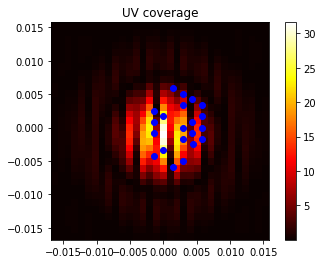

In [27]:
X, Y, sigma = dataset[0]
fft = np.abs(np.fft.fftshift(np.fft.fft2(Y[..., 0])))[0]

uv = phys.operators.UVC
wavel = args.wavelength
rho = np.hypot(uv[:, 0], uv[:, 1])
fftfreq = np.fft.fftshift(np.fft.fftfreq(phys.pixels, phys.plate_scale))

im = plt.imshow(np.abs(fft), cmap="hot", extent=[fftfreq.min(), fftfreq.max()] * 2)
ufreq = 1 / rad2mas(1 / uv[:, 0] * wavel)
vfreq = 1 / rad2mas(1 / uv[:, 1] * wavel)
plt.plot(ufreq, vfreq, "bo")
plt.colorbar(im)
plt.title("UV coverage")